In [20]:
# Türkçe karakterlerin doğru bir şekilde görüntülenmesi için çıktı formatını ayarlayın
import sys
from io import StringIO

# Mevcut stdout'u yedekleyin
old_stdout = sys.stdout
sys.stdout = StringIO()  # StringIO ile yeni bir çıktı akışı oluşturun

# Burada UTF-8 çıktısını alabilmek için örnek bir yazdırma işlemi
print("Türkçe karakterler: ğüşıöç")

# stdout'u eski haline getirin
sys.stdout = old_stdout
import warnings
warnings.filterwarnings("ignore")

1. Belirli sayıda paket yakala ve analiz et
2. Sürekli paket yakala ve analiz et
3. Belirli bir IP'ye ping gönder
Bir işlem seçin (1/2/3): 1
Kaç paket yakalamak istiyorsunuz?: 5
Hangi arayüzden paket yakalamak istiyorsunuz? (örneğin: Wi-Fi): Wi-Fi
Wi-Fi arayüzünden paket yakalanıyor...
IP katmanı bulunmayan bir paket yakalandı.
ARP Paketi Yakalandı: Ether / ARP who has 172.31.89.199 says 172.31.88.82 / Padding
Kaynak IP: 172.31.88.209 - Hedef IP: 74.125.143.188 - Protokol: 6 - Paket Boyutu: 55 byte
TCP Paketi Yakalandı: Ether / IP / TCP 172.31.88.209:55929 > 74.125.143.188:5228 A / Raw
Kaynak IP: 74.125.143.188 - Hedef IP: 172.31.88.209 - Protokol: 6 - Paket Boyutu: 66 byte
TCP Paketi Yakalandı: Ether / IP / TCP 74.125.143.188:5228 > 172.31.88.209:55929 A
IP katmanı bulunmayan bir paket yakalandı.
ARP Paketi Yakalandı: Ether / ARP who has 172.31.88.88 says 172.31.88.97 / Padding
IP katmanı bulunmayan bir paket yakalandı.
ARP Paketi Yakalandı: Ether / ARP who has 172.31.90.64 says 172.3

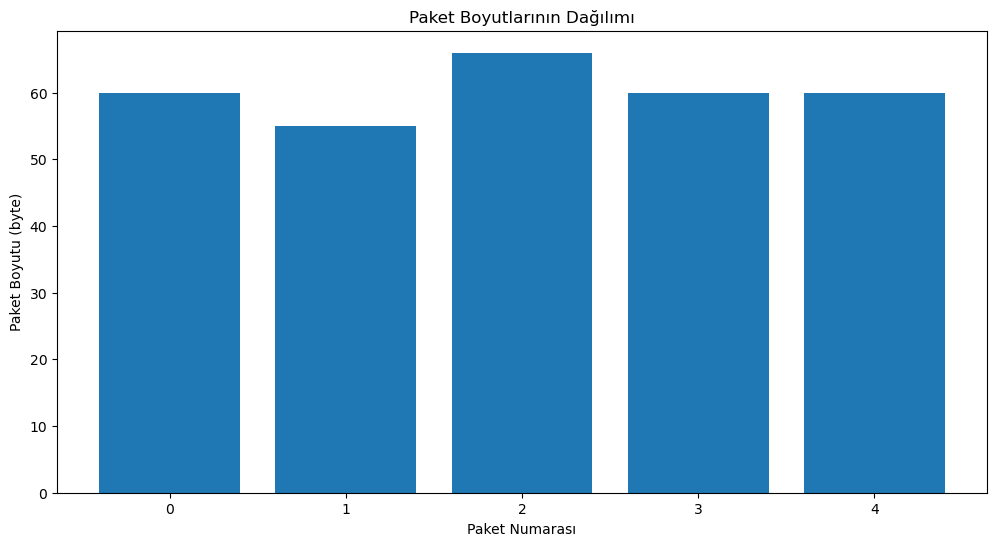

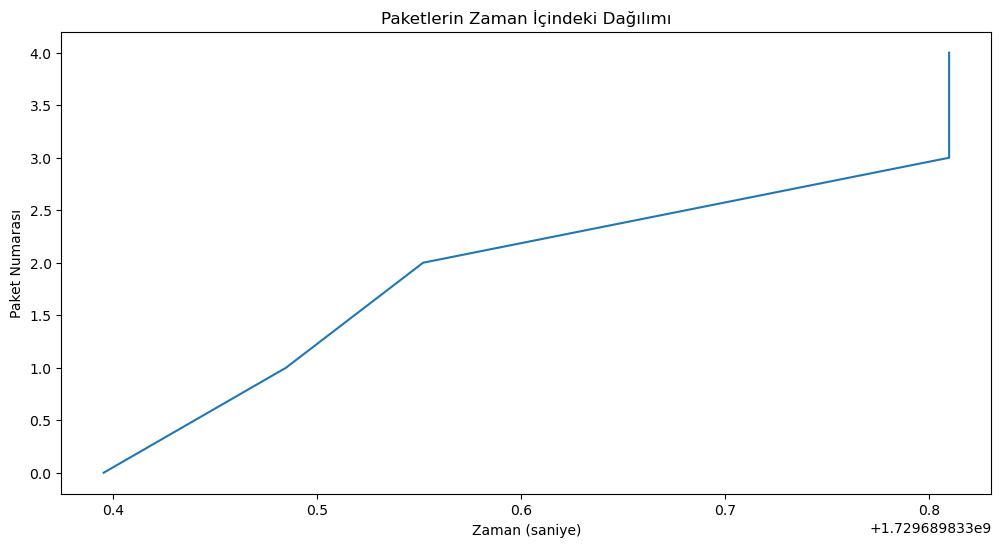

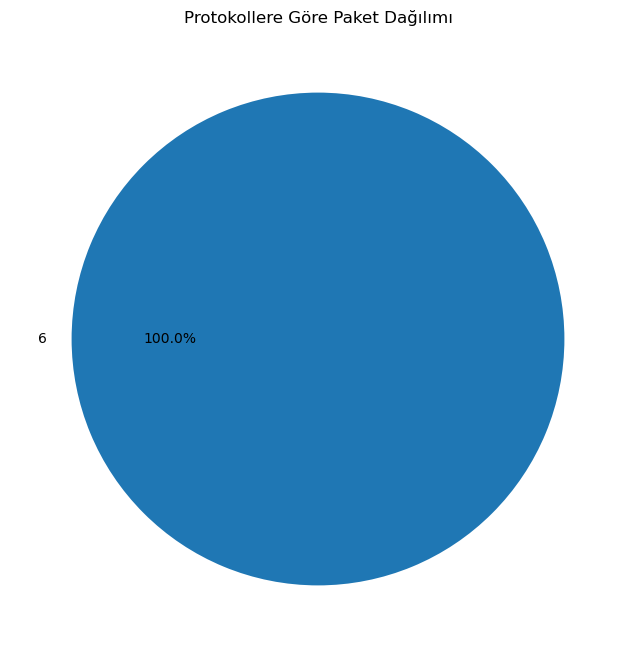

Model Doğruluğu: 100.00%


In [19]:
# Veri Paket Analiz Aracı Projesi
# Bu proje, canlı veri paketlerini yakalama, analiz etme, grafiklerle görselleştirme
# ve makine öğrenimi ile analiz sonuçlarını değerlendirme gibi işlemleri gerçekleştirir.
# Hocam kod karışık gözükebilir ama yazarken kendimi geliştirmek ve gerçekten öğrenmek için notlarımı kod satırına yazdım.
#Chatgptden ve internetten fazlasıyla yardım aldım çünkü pyhtonda ağ canlı verileri analiz ,tarama, yakalama, izleme, toplama
#gibisinden işlemler nasıl yapıldığını bilmiyordum.
#Ve ayrıca projenin içinde çokça kurulması gereken kütüpane bulunduğu için başka bilgsayarda sağlıklı çalışmayabilir o yüzden
#çalıştığı haliyle göstermek istedim.

from scapy.all import sniff, wrpcap, IP, ICMP, send
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import time

# Paket bilgilerini toplamak için küresel listeler
my_packet_sizes = []  # Paket boyutlarını saklamak için
my_timestamps = []  # Paketlerin zaman damgalarını saklamak için
my_protocol_counts = Counter()  # Protokol sayımlarını saklamak için
my_data = []  # Makine öğrenimi için kullanılacak veri listesi

# 1. Canlı Veri Paketlerini Yakalama ve İşleme
def process_mypacket(mypacket):
    global my_packet_sizes, my_timestamps, my_protocol_counts, my_data

    # Zaman damgasını ve paket boyutunu kaydet
    my_timestamps.append(mypacket.time)  # Paket geldiği zaman
    my_packet_sizes.append(len(mypacket))  # Paket boyutunu kaydet

    # Protokollere göre sayma ve IP bilgilerini yazdırma
    if mypacket.haslayer(IP):  # Eğer paket IP katmanı içeriyorsa
        src_ip = mypacket[IP].src  # Kaynak IP adresi
        dst_ip = mypacket[IP].dst  # Hedef IP adresi
        proto = mypacket[IP].proto  # Protokol numarası
        print(f"Kaynak IP: {src_ip} - Hedef IP: {dst_ip} - Protokol: {proto} - Paket Boyutu: {len(mypacket)} byte")
        
        # Protokolü say
        my_protocol_counts[proto] += 1  # Protokol sayısını artır
        
        # Veriyi topla
        my_data.append([src_ip, dst_ip, proto, len(mypacket), mypacket.time])  # Özellikler olarak sakla
    else:
        print("IP katmanı bulunmayan bir paket yakalandı.")  # IP katmanı yoksa uyarı ver

    # ARP, TCP ve UDP gibi protokoller için ek bilgi yazdır
    if mypacket.haslayer('TCP'):
        print(f"TCP Paketi Yakalandı: {mypacket.summary()}")  # TCP paketlerini göster
    elif mypacket.haslayer('UDP'):
        print(f"UDP Paketi Yakalandı: {mypacket.summary()}")  # UDP paketlerini göster
    elif mypacket.haslayer('ARP'):
        print(f"ARP Paketi Yakalandı: {mypacket.summary()}")  # ARP paketlerini göster
    else:
        print("Bilinmeyen protokole sahip bir paket yakalandı.")  # Bilinmeyen bir protokol

# 2. paket grafik
def visualize_data():
    global my_packet_sizes, my_timestamps, my_protocol_counts

    # paket grafik çiziliyor
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(my_packet_sizes)), my_packet_sizes)  # paket boyutları çubuk grafiği
    plt.xlabel('Paket Numarası')  # X ekseni için etiket
    plt.ylabel('Paket Boyutu (byte)')  # Y ekseni için etiket
    plt.title('Paket Boyutlarının Dağılımı')  # Grafik başlığı
    plt.show()  

    # Paketlerin zaman damgalarını çiz
    plt.figure(figsize=(12, 6))
    plt.plot(my_timestamps, range(len(my_timestamps)))  # Zaman damgalarını çiz
    plt.xlabel('Zaman (saniye)')  # Zaman için etiket
    plt.ylabel('Paket Numarası')  # Paket numarası için etiket
    plt.title('Paketlerin Zaman İçindeki Dağılımı')  
    plt.show()  # Grafiği göster

    # Protokol dağılımını pasta grafiği olarak göster
    plt.figure(figsize=(8, 8))
    plt.pie([my_protocol_counts[proto] for proto in my_protocol_counts], labels=[str(proto) for proto in my_protocol_counts], autopct='%1.1f%%')
    plt.title('Protokollere Göre Paket Dağılımı')  
    plt.show()  # Grafiği göster

# 3. Paketleri PCAP Dosyasına Kaydetme
def save_mypackets(mypackets):
    wrpcap("yakalanan_paketler.pcap", mypackets)  # Paketleri PCAP dosyasına kaydet
    print("Paketler pcap dosyasına kaydedildi: yakalanan_paketler.pcap")

# 4. ICMP (Ping) Paketi Gönderme - Ağdaki Belirli Bir IP'ye Ping Atma
def send_ping(dst_ip):
    mypacket = IP(dst=dst_ip)/ICMP()  # ICMP ping paketi oluştur
    send(mypacket)  # Paketi gönder
    print(f"{dst_ip} adresine ICMP (ping) paketi gönderildi.")  # Gönderim bilgisini yazdır

# 5. Canlı Paket Yakalama - Belirli Bir Süre veya Paket Sayısına Göre
def capture_mypackets(interface="Wi-Fi", count=10, timeout=None):
    print(f"{interface} arayüzünden paket yakalanıyor...")
    mypackets = sniff(iface=interface, prn=process_mypacket, count=count, timeout=timeout)  # Paketleri yakala
    save_mypackets(mypackets)  # Yakalanan paketleri kaydet
    visualize_data()  # Verileri görselleştir
    train_model()  # Modeli eğit

# 6. Sürekli Veri Yakalama (Sonsuz Döngü ile Paket İşleme)
def continuous_capture(interface="Wi-Fi"):
    print(f"{interface} arayüzünden sürekli paket yakalanıyor... Çıkış yapmak için CTRL+C")
    sniff(iface=interface, prn=process_mypacket, store=0)  # Sürekli paket yakala

# 7. Makine Öğrenimi Modelini Eğitme
def train_model():
    global my_data
    if len(my_data) > 0:  # Yeterli veri varsa
        # DataFrame'e dönüştür
        df = pd.DataFrame(my_data, columns=["src_ip", "dst_ip", "protocol", "size", "timestamp"])

        # Protokolü sayısal verilere çevir
        df["protocol"] = df["protocol"].astype(int)  # Protokolü sayısal formata çevir

        # Özellikler ve hedefi ayır
        X = df[["protocol", "size"]]  # Giriş özellikleri
        y = df["protocol"]  # Hedef değişken olarak protokolü kullanıyoruz

        # Eğitim ve test setlerine ayır
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  # Veriyi eğitim ve test setlerine ayır

        # Modeli eğit
        model = RandomForestClassifier()  # Random Forest modeli oluştur
        model.fit(X_train, y_train)  # Modeli eğitim verisi ile eğit

        # Model doğruluğunu kontrol et
        accuracy = model.score(X_test, y_test)  # Test seti ile doğruluk oranını hesapla
        print(f"Model Doğruluğu: {accuracy * 100:.2f}%")  # Sonucu yazdır
    else:
        print("Eğitim için yeterli veri yok.")  # Yeterli veri yoksa uyarı ver

# 8. Çalıştırma Fonksiyonu
if __name__ == "__main__":
    # Kullanıcıdan işlem seçimi al
    print("1. Belirli sayıda paket yakala ve analiz et")
    print("2. Sürekli paket yakala ve analiz et")
    print("3. Belirli bir IP'ye ping gönder")
    choice = input("Bir işlem seçin (1/2/3): ")

    if choice == "1":
        count = int(input("Kaç paket yakalamak istiyorsunuz?: "))  # Kaç paket yakalanacağına dair giriş
        interface = input("Hangi arayüzden paket yakalamak istiyorsunuz? (örneğin: Wi-Fi): ")  # Arayüz seçimi
        capture_mypackets(interface=interface, count=count)  # Paketleri yakala
    elif choice == "2":
        interface = input("Hangi arayüzden sürekli paket yakalamak istiyorsunuz? (örneğin: Wi-Fi): ")  # Arayüz seçimi
        continuous_capture(interface=interface)  # Sürekli paket yakala
    elif choice == "3":
        dst_ip = input("Hedef IP adresini girin: ")  # Hedef IP girişi
        send_ping(dst_ip)  # Ping gönder
    else:
        print("Geçersiz seçim!")  # Geçersiz seçim uyarısı


In [15]:

if __name__ == "__main__":
    # Kullanıcıdan işlem seçimi al
    print("1. Belirli sayıda paket yakala ve analiz et")
    print("2. Sürekli paket yakala ve analiz et")
    print("3. Belirli bir IP'ye ping gönder")
    choice = input("Bir işlem seçin (1/2/3): ")

    if choice == "1":
        count = int(input("Kaç paket yakalamak istiyorsunuz?: "))
        interface = input("Hangi arayüzden paket yakalamak istiyorsunuz? (örneğin: Wi-Fi): ")
        capture_mypackets(interface=interface, count=count)
    elif choice == "2":
        interface = input("Hangi arayüzden sürekli paket yakalamak istiyorsunuz? (örneğin: Wi-Fi): ")
        continuous_capture(interface=interface)
    elif choice == "3":
        ip_address = input("Ping göndermek istediğiniz IP adresini girin: ")
        send_ping(ip_address)
    else:
        print("Geçersiz seçim. Lütfen 1, 2 veya 3 girin.")


1. Belirli sayıda paket yakala ve analiz et
2. Sürekli paket yakala ve analiz et
3. Belirli bir IP'ye ping gönder
Bir işlem seçin (1/2/3): 3
Ping göndermek istediğiniz IP adresini girin: 192.168.1.1

Sent 1 packets.
192.168.1.1 adresine ICMP (ping) paketi gönderildi.


In [16]:
if __name__ == "__main__":
    # Kullanıcıdan işlem seçimi al
    print("1. Belirli sayıda paket yakala ve analiz et")
    print("2. Sürekli paket yakala ve analiz et")
    print("3. Belirli bir IP'ye ping gönder")
    choice = input("Bir işlem seçin (1/2/3): ")

    if choice == "1":
        count = int(input("Kaç paket yakalamak istiyorsunuz?: "))
        interface = input("Hangi arayüzden paket yakalamak istiyorsunuz? (örneğin: Wi-Fi): ")
        capture_mypackets(interface=interface, count=count)
    elif choice == "2":
        interface = input("Hangi arayüzden sürekli paket yakalamak istiyorsunuz? (örneğin: Wi-Fi): ")
        continuous_capture(interface=interface)
    elif choice == "3":
        ip_address = input("Ping göndermek istediğiniz IP adresini girin: ")
        send_ping(ip_address)
    else:
        print("Geçersiz seçim. Lütfen 1, 2 veya 3 girin.")

1. Belirli sayıda paket yakala ve analiz et
2. Sürekli paket yakala ve analiz et
3. Belirli bir IP'ye ping gönder
Bir işlem seçin (1/2/3): 2
Hangi arayüzden sürekli paket yakalamak istiyorsunuz? (örneğin: Wi-Fi): Wi-Fi
Wi-Fi arayüzünden sürekli paket yakalanıyor... Çıkış yapmak için CTRL+C
Kaynak IP: 13.68.233.9 - Hedef IP: 172.31.88.209 - Protokol: 6 - Paket Boyutu: 60 byte
TCP Paketi Yakalandı: Ether / IP / TCP 13.68.233.9:https > 172.31.88.209:55994 A / Padding
Kaynak IP: 13.68.233.9 - Hedef IP: 172.31.88.209 - Protokol: 6 - Paket Boyutu: 60 byte
TCP Paketi Yakalandı: Ether / IP / TCP 13.68.233.9:https > 172.31.88.209:55994 A / Padding
Kaynak IP: 13.68.233.9 - Hedef IP: 172.31.88.209 - Protokol: 6 - Paket Boyutu: 1514 byte
TCP Paketi Yakalandı: Ether / IP / TCP 13.68.233.9:https > 172.31.88.209:55994 A / Raw
Kaynak IP: 13.68.233.9 - Hedef IP: 172.31.88.209 - Protokol: 6 - Paket Boyutu: 861 byte
TCP Paketi Yakalandı: Ether / IP / TCP 13.68.233.9:https > 172.31.88.209:55994 PA / Raw
K